<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/HumanActivityCNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# ===================== 데이터 로드 =====================
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/ML_Class/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/ML_Class/')
    trainy, testy = trainy - 1, testy - 1
    trainy_one_hot, testy_one_hot = to_categorical(trainy), to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot


# ===================== 데이터 분할 =====================
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

print(X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape, y_train.shape, y_val.shape)


/tmp/ipython-input-1486747937.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1486747937.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1486747937.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1486747937.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6) (5881, 1) (1471, 1)


In [4]:
# ===================== CNN-LSTM 모델 =====================
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

cnn_lstm = Sequential([
    # CNN 블록: 지역적 특징 추출
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Dropout(0.5),

    # LSTM 블록: 시계열 의존성 학습
    LSTM(128, return_sequences=False),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs, activation='softmax')
])

cnn_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

cnn_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,726 (651.27 KB)

 Trainable params: 166,726 (651.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5269 - loss: 1.1051 - val_accuracy: 0.8729 - val_loss: 0.3591
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8500 - loss: 0.4244 - val_accuracy: 0.8810 - val_loss: 0.3098
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9313 - loss: 0.2091 - val_accuracy: 0.9354 - val_loss: 0.1779
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9401 - loss: 0.1775 - val_accuracy: 0.9422 - val_loss: 0.1504
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9374 - loss: 0.1763 - val_accuracy: 0.9327 - val_loss: 0.1649
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9381 - loss: 0.1659 - val_accuracy: 0.9252 - val_loss: 0.1686
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9440 - loss: 0.1302 - val_accuracy: 0.9517 - val_loss: 0.1257
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9494 - loss: 0.1506 - val_accurac

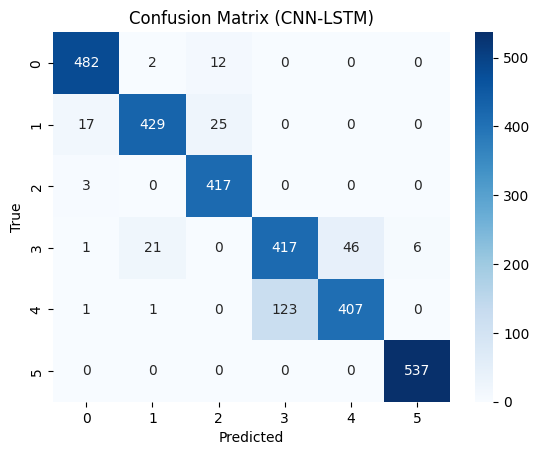

In [5]:
# ===================== 학습 =====================
history = cnn_lstm.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)


# ===================== 평가 =====================
pred = cnn_lstm.predict(testX)
pred = np.argmax(pred, axis=-1)

cm = confusion_matrix(testy, pred)
print("Accuracy:", accuracy_score(testy, pred))
print(classification_report(testy, pred))

sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix (CNN-LSTM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

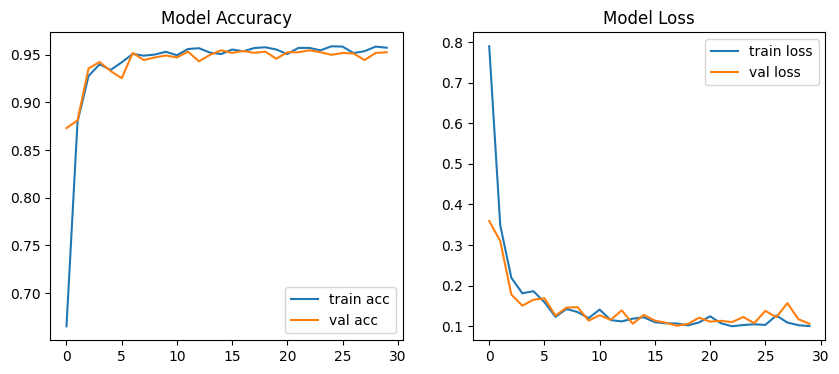

In [6]:

# ===================== 학습 곡선 시각화 =====================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.legend()
plt.show()
